In [1]:
#https://github.com/znxlwm/pytorch-generative-model-collections
import utils, torch, time, os, pickle, itertools
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.utils.data as Utils
from skimage import io
from PIL import Image
import os
from matplotlib import pyplot as plt
% matplotlib inline

# % mogrify -resize 128x128 *.jpg

In [2]:
if not os.path.exists('models'):
    os.makedirs('models')

# --result_dir
if not os.path.exists('results'):
    os.makedirs('results')

# --result_dir
if not os.path.exists('logs'):
    os.makedirs('logs')

In [3]:
def load_image(file_name):
    data = io.imread(file_name, as_grey=False)
    data = np.array(data, order='F')
    data = torch.from_numpy(data).transpose(0,2)
#     data = np.expand_dims(data,axis=0)
    return data

torch.Size([3, 64, 64])
torch.Size([64, 64, 3])


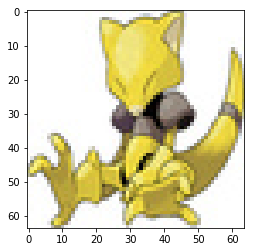

In [4]:
a = load_image("Pokemon/abra.jpg")
# a = np.expand_dims(a,axis=4)
print(a.shape)
a = a.transpose(0,2)
print(a.shape)

plt.gray()
plt.imsave('image.png', a)
plt.imshow(a)
plt.show()

In [5]:
class VoiceSets(Utils.Dataset): # Main dataset class for dataloader
    def __init__(self, inputs, target): # takes two input, the input and output Tensors
        self.inputwave = inputs
        self.targetwave = target
        self.len = len(self.inputwave) # number of input, NOT LENGTH OF INPUT --> LENGTH OF INPUT = 4000 in our case
        
    def __len__(self): # must be written for dataset module
        return self.len
    
    def __getitem__(self,index): # must be written for dataset module
        return self.inputwave[index], self.targetwave[index] # call for input, target on Training block

# STANDARD GAN

In [ ]:
class generator(nn.Module):
    def __init__(self, dataset = 'pokemon'):
        super(generator, self).__init__()
        if dataset == 'mnist' or dataset == 'fashion-mnist':
            self.input_height = 28
            self.input_width = 28
            self.input_dim = 62
            self.output_dim = 1
        elif dataset == 'celebA':
            self.input_height = 64
            self.input_width = 64
            self.input_dim = 62
            self.output_dim = 3
        elif dataset == 'pokemon':
            self.input_height = 64
            self.input_width = 64
            self.input_dim = 64
            self.output_dim = 3

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_height // 4) * (self.input_width // 4)),
            nn.BatchNorm1d(128 * (self.input_height // 4) * (self.input_width // 4)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Sigmoid(),
        )
        utils.initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, (self.input_height // 4), (self.input_width // 4))
        x = self.deconv(x)

        return x

In [ ]:
class discriminator(nn.Module):
    def __init__(self, dataset = 'pokemon'):
        super(discriminator, self).__init__()
        if dataset == 'mnist' or dataset == 'fashion-mnist':
            self.input_height = 28
            self.input_width = 28
            self.input_dim = 1
            self.output_dim = 1
        elif dataset == 'celebA':
            self.input_height = 64
            self.input_width = 64
            self.input_dim = 3
            self.output_dim = 1
        elif dataset == 'pokemon':
            self.input_height = 64
            self.input_width = 64
            self.input_dim = 3
            self.output_dim = 1
            
        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_height // 4) * (self.input_width // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )
        utils.initialize_weights(self)

    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * (self.input_height // 4) * (self.input_width // 4))
        x = self.fc(x)

        return x

In [ ]:
class GAN(object):
    def __init__(self):
        # parameters
        self.epoch = 500
        self.sample_num = 32
        self.batch_size = 32
        self.save_dir = 'models'
        self.result_dir = 'results'
        self.dataset = 'pokemon'
        self.log_dir = 'logs'
        self.gpu_mode = True
        self.model_name = 'GAN'
        self.lrG = 0.0001
        self.lrD = 0.0001
        self.beta1 = 0.4
        self.beta2 = 0.999
        

        # networks initmnist
        self.G = generator(self.dataset)
        self.D = discriminator(self.dataset)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=self.lrG, betas=(self.beta1, self.beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=self.lrD, betas=(self.beta1, self.beta2))

        if self.gpu_mode:
            self.G.cuda()
            self.D.cuda()
            self.BCE_loss = nn.BCELoss().cuda()
        else:
            self.BCE_loss = nn.BCELoss()

        # load dataset
        if self.dataset == 'mnist':
            self.data_loader = DataLoader(datasets.MNIST('data/mnist', train=True, download=True,
                                                                          transform=transforms.Compose(
                                                                              [transforms.ToTensor()])),
                                                           batch_size=self.batch_size, shuffle=True)
        elif self.dataset == 'fashion-mnist':
            self.data_loader = DataLoader(
                datasets.FashionMNIST('data/fashion-mnist', train=True, download=True, transform=transforms.Compose(
                    [transforms.ToTensor()])),
                batch_size=self.batch_size, shuffle=True)
        elif self.dataset == 'celebA':
            self.data_loader = utils.load_celebA('data/celebA', transform=transforms.Compose(
                [transforms.CenterCrop(160), transforms.Scale(64), transforms.ToTensor()]), batch_size=self.batch_size,
                                                 shuffle=True)
        elif self.dataset == 'pokemon':
            fs = !ls Pokemon *.jpg
            fs = fs[2:]
            poke_trn = []
            for name in fs:
                poke_trn.append(load_image('Pokemon/' + name))  
                
            fs = !ls FlipPokemon *.jpg
            fs = fs[2:]
            for name in fs:
                poke_trn.append(load_image('FlipPokemon/' + name))
            dataset = VoiceSets(poke_trn, poke_trn)
            self.data_loader = Utils.DataLoader(dataset=dataset, shuffle = True, batch_size=self.batch_size)
            
        self.z_dim = 64

        # fixed noise
        if self.gpu_mode:
            self.sample_z_ = Variable(torch.rand((self.batch_size, self.z_dim)).cuda(), volatile=True)
        else:
            self.sample_z_ = Variable(torch.rand((self.batch_size, self.z_dim)), volatile=True)
    
    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []
        self.train_hist['per_epoch_time'] = []
        self.train_hist['total_time'] = []

        if self.gpu_mode:
            self.y_real_, self.y_fake_ = Variable(torch.ones(self.batch_size, 1).cuda()), Variable(torch.zeros(self.batch_size, 1).cuda())
        else:
            self.y_real_, self.y_fake_ = Variable(torch.ones(self.batch_size, 1)), Variable(torch.zeros(self.batch_size, 1))

        self.D.train()
        print('training start!!')
        start_time = time.time()
        for epoch in range(self.epoch):
            self.G.train()
            epoch_start_time = time.time()
            for iter, (x_,_) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break
                    
                x_ = x_.type(torch.FloatTensor)
                
                z_ = torch.rand((self.batch_size, self.z_dim))
               
                if self.gpu_mode:
                    x_, z_ = Variable(x_.cuda()), Variable(z_.cuda())
                else:
                    x_, z_ = Variable(x_), Variable(z_)
    
                # update D network
                self.D_optimizer.zero_grad()
                
                D_real = self.D(x_)
                D_real_loss = self.BCE_loss(D_real, self.y_real_)

                G_ = self.G(z_)

                D_fake = self.D(G_)
                D_fake_loss = self.BCE_loss(D_fake, self.y_fake_)

                D_loss = D_real_loss + D_fake_loss
                self.train_hist['D_loss'].append(D_loss.data[0])

                D_loss.backward()
                self.D_optimizer.step()

                # update G network
                self.G_optimizer.zero_grad()

                G_ = self.G(z_)
                D_fake = self.D(G_)
                G_loss = self.BCE_loss(D_fake, self.y_real_)
                self.train_hist['G_loss'].append(G_loss.data[0])

                G_loss.backward()
                self.G_optimizer.step()

                if ((iter + 1) % 100) == 0:
                    print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.data[0], G_loss.data[0]))

            self.train_hist['per_epoch_time'].append(time.time() - epoch_start_time)
            if ((epoch + 1)%25 == 0) or (epoch == 0):
                self.visualize_results((epoch+1)/25)

        self.train_hist['total_time'].append(time.time() - start_time)
        print("Avg one epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(self.train_hist['per_epoch_time']),
              self.epoch, self.train_hist['total_time'][0]))
        print("Training finish!... save training results")

        self.save()
        utils.generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name,
                                 ((self.epoch+1)//25))
        utils.loss_plot(self.train_hist, os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name)

    def visualize_results(self, epoch, fix=False):
        self.G.eval()

        if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
            os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)

        tot_num_samples = min(self.sample_num, self.batch_size)
        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))

        if fix:
            """ fixed noise """
            samples = self.G(self.sample_z_)
        else:
            """ random noise """
            if self.gpu_mode:
                sample_z_ = Variable(torch.rand((self.batch_size, self.z_dim)).cuda(), volatile=True)
            else:
                sample_z_ = Variable(torch.rand((self.batch_size, self.z_dim)), volatile=True)
            samples = self.G(sample_z_)
        if self.gpu_mode:
            samples = samples.cpu().data.numpy().transpose(0, 3, 2, 1)
        else:
            samples = samples.data.numpy().transpose(0, 2, 3, 1)
        utils.save_images(samples[:image_frame_dim * image_frame_dim, :, :, :], [image_frame_dim, image_frame_dim],
                          self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')

    def save(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        torch.save(self.G.state_dict(), os.path.join(save_dir, self.model_name + '_G.pkl'))
        torch.save(self.D.state_dict(), os.path.join(save_dir, self.model_name + '_D.pkl'))

        with open(os.path.join(save_dir, self.model_name + '_history.pkl'), 'wb') as f:
            pickle.dump(self.train_hist, f)

    def load(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)

        self.G.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_G.pkl')))
        self.D.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_D.pkl')))

In [ ]:
gan = GAN()

gan.train()
print(" [*] Training finished!")

In [ ]:
utils.generate_animation('results/pokemon/GAN/GAN',15)